# Transportion
Predict whether a passenger was transported using personal records.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time

train=r'/kaggle/input/spaceship-titanic/train.csv'
test=r'/kaggle/input/spaceship-titanic/test.csv'

df=pd.read_csv(train)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Target Variable
Transported is in independent variable being analyzed with 4378 survived and 4315 did not survive. 

In [2]:
df['Transported']=df['Transported'].astype('str').replace({'False':0, 'True':1})

In [3]:
df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

# Find Missing Values

In [4]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head(4))
findNA() 

Missing data by column as a percent:
CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
dtype: float64


# Find Categorical Variables

In [5]:
cols=df.select_dtypes(include='object').columns
for col in cols:
    print(col)
    print(df[col].value_counts())
    print("")

PassengerId
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

CryoSleep
False    5439
True     3037
Name: CryoSleep, dtype: int64

Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

VIP
False    8291
True      199
Name: VIP, dtype: int64

Name
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Nam

# Feature Engineer

In [6]:
df['VIP']=df['VIP'].astype('str').replace({'False':0, 'True':1})
df['CryoSleep']=df['CryoSleep'].astype('str').replace({'False':0, 'True':1})
df['HomePlanet']=df['HomePlanet'].replace({'Earth':2, 'Europa':1, 'Mars':0})

In [7]:
df['Cabin']=df['Cabin'].astype('str').str[0]
df['Cabin'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
n     199
T       5
Name: Cabin, dtype: int64

In [8]:
cabinDic={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'n':7, 'T':8}
df['Cabin']=df['Cabin'].replace(cabinDic)

In [9]:
df['Destination']=df['Destination'].astype('str').str[0]
destDic={'T':2, '5':1, 'P':0}
df['Destination']=df['Destination'].replace(destDic)

### Put First and Last name in column.
* Gender: first name can creature a gender feature.
* Family: last name can possibly detect if person is alone.

In [10]:
df[['First','Last']] = df.Name.apply(lambda x: pd.Series(str(x).split(" ")))
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,First,Last
0,0001_01,1.0,0,1,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,Maham,Ofracculy
1,0002_01,2.0,0,5,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,Juanna,Vines
2,0003_01,1.0,0,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,Altark,Susent
3,0003_02,1.0,0,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,Solam,Susent
4,0004_01,2.0,0,5,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,Willy,Santantines


In [11]:
numList=[]
lastUnique=list(df['Last'].unique())
for name in df['Last']:
    #print(name)
    if str(name) not in lastUnique:
        numList.append(1)
    else:
        numList.append(0)
df['Alone']=numList
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,First,Last,Alone
0,0001_01,1.0,0,1,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,Maham,Ofracculy,0
1,0002_01,2.0,0,5,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,Juanna,Vines,0
2,0003_01,1.0,0,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,Altark,Susent,0
3,0003_02,1.0,0,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,Solam,Susent,0
4,0004_01,2.0,0,5,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,Willy,Santantines,0


In [12]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,First,Last,Alone
0,0001_01,1.0,0,1,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,Maham,Ofracculy,0
1,0002_01,2.0,0,5,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,Juanna,Vines,0
2,0003_01,1.0,0,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,Altark,Susent,0
3,0003_02,1.0,0,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,Solam,Susent,0
4,0004_01,2.0,0,5,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,Willy,Santantines,0


# Numeric DataFrame

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df= df.fillna(df.mean())
df.head()

,HomePlanet,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Alone
0,1.0,1,39.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2.0,5,24.0,109.0,9.0,25.0,549.0,44.0,1,0
2,1.0,0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0
3,1.0,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0
4,2.0,5,16.0,303.0,70.0,151.0,565.0,2.0,1,0


# Split Data

In [14]:
X=df.drop('Transported', axis=1)
y=df['Transported']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

# Gradient Boost
* 2  max_depth || AUC  0.8563  || MSE 0.1542
* 3  max_depth || AUC  0.8637  || MSE 0.1482
* 4  max_depth || AUC  0.8681  || MSE 0.1444
* 5  max_depth || AUC  0.8715  || MSE 0.1435
* 7  max_depth || AUC  0.8686  || MSE 0.1453
* 9  max_depth || AUC  0.856  || MSE 0.1533
* 11  max_depth || AUC  0.8488  || MSE 0.1597
* 100  n_estimators || AUC  0.8285  || MSE 0.1924
* 200  n_estimators || AUC  0.8427  || MSE 0.1711
* 300  n_estimators || AUC  0.8485  || MSE 0.1616
* 400  n_estimators || AUC  0.8537  || MSE 0.1568
* 500  n_estimators || AUC  0.8563  || MSE 0.1542
* 600  n_estimators || AUC  0.8587  || MSE 0.1525

In [15]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5, 7, 9, 11]
    
    for d in depthList:
        params = {
         "n_estimators": 500, "max_depth": d, "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        #print("Gradient boosting regression r2: ", gbr_r2) 

        #calculate AUC of model
        auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(d," max_depth || AUC ", auc, " || MSE {:.4f}".format(mse))

def gbN():
    nList=[100, 200, 300, 400, 500, 600]
    
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        #print("Gradient boosting regression r2: ", gbr_r2) 

        #calculate AUC of model
        auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(n," n_estimators || AUC ", auc, " || MSE {:.4f}".format(mse))

def gbSplit():
    sList=[2, 3, 5, 7]
    
    for s in sList:
        params = {
         "n_estimators": 500, "max_depth": 2,
            "min_samples_split": s, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        #print("Gradient boosting regression r2: ", gbr_r2) 

        #calculate AUC of model
        auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(s," min_samples_splits || AUC ", auc, " || MSE {:.4f}".format(mse))

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

In [16]:
params = {
 "n_estimators": 600, "max_depth": 5, 
    "min_samples_split": 7, "learning_rate": 0.01,
}

#Fit and Predict:
reg = ensemble.GradientBoostingClassifier(**params)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

#AUC of model
auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for gradient boost is: ", auc)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Gradient boosting regression r2:  0.1717
AUC for gradient boost is:  0.7933
The mean squared error (MSE) on test set: 0.2071


# Feature Importance

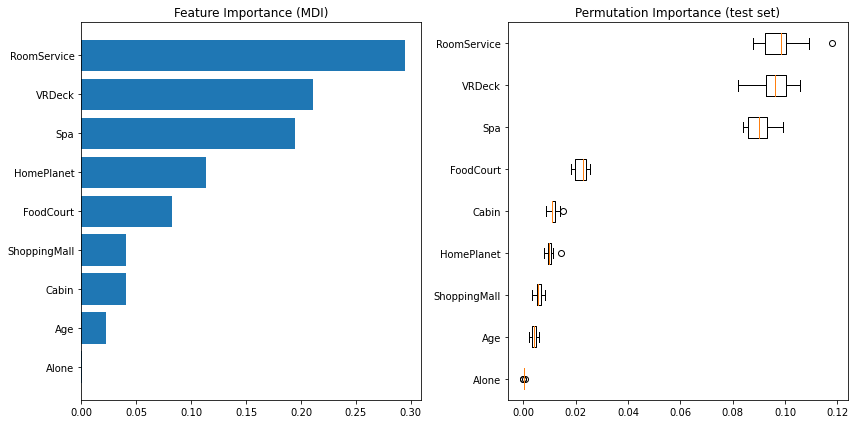

In [17]:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='liblinear') #solver param gets rid of encoder error

#Train the model and create predictions
logReg.fit(X_train, y_train)
logPredict = logReg.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
print("AUC for logistic regression is: ", auc)

#CROSS VALIDATE TEST RESULTS:
logScore = logReg.score(X_test, y_test).round(4)  # train test 
print("Logistic Accuracy: ", logScore)
logCV = cross_validate(logReg, X, y, cv = 5, scoring= 'r2')
logCV=logCV['test_score'].mean().round(4)
print(logCV, " Logistic Regression cross validate")

AUC for logistic regression is:  0.8511
Logistic Accuracy:  0.7753
0.1087  Logistic Regression cross validate


# Linear Regression

AUC for linear regression is:  0.7998
Linear regression r2 score:  0.1984
Linear Accuracy:  0.1984
0.1942  linear regression cross validate mean


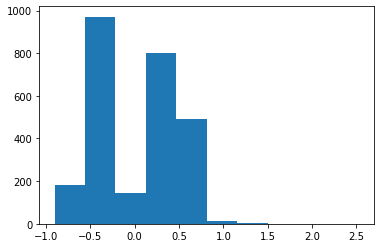

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
print("AUC for linear regression is: ", auc)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)
    np.sqrt(metrics.mean_squared_error(y_test, lrPredict))

# Decision Tree
* 11  best max_depth parameter with least MAE
* 500  best max_leaf_node

The full dictionaries are below:

{2: 0.3908, 3: 0.3534, 5: 0.3056, 7: 0.2883, 9: 0.2787, 11: 0.276, 15: 0.2868}

{5: 0.3672, 25: 0.2988, 50: 0.2905, 100: 0.2834, 250: 0.2831, 500: 0.2829, 700: 0.2888}


In [20]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500, 700]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size, " best max_leaf_node") #500 is best
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7, 9, 11, 15]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeRegressor(max_leaf_nodes=500, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
    print(maeDic)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth parameter with least MAE") #11
    
def automateTree():
    print("Decision Tree Automating:")
    start=time.time()
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
            
            aucList.append(treeAUC)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
            
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['AUC'], ascending=True)
    print("Done. ", round(time.time()-start,4), " seconds")
    return df

#calcDepth() 
#calcLeaf()
#treeDF=automateTree()
#treeDF.head()

### Decision Tree Overfitting:
Decision tree tends to overfit data which is clearly happening in this case:
* AUC for decision tree is:  0.9187
* R-squared for decision tree is:  0.5415
* 0.3099  Tree cross validate mean

Line graphs should help show where the decision tree parameters should truly be set at. The train data results should correlated with the final test data. 

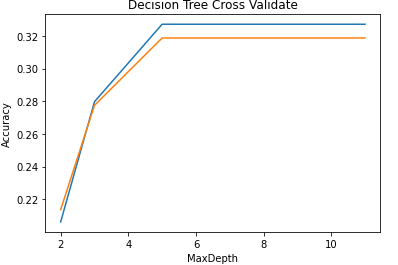
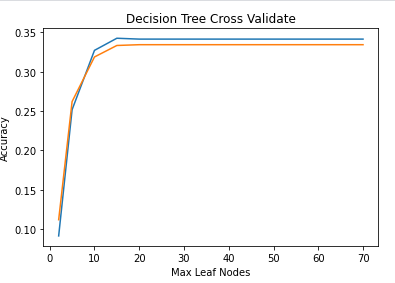

In [21]:
def validateTreeDepth():
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    accList=[]
    cvList=[]
    maeList=[]
    
    maxLeafNodesList=[]
    maxDepthList=[]

    for d in max_depth_list:
        maxDepthList.append(d)
        
        tree = DecisionTreeRegressor(max_leaf_nodes=10, max_depth=d, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)
        accList.append(treeR2)

        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        #print(treeCV, " Decision Tree cross validate.")
       # print(treeCV-treeR2, " validation error")
    plt.plot(maxDepthList,accList, label="line1")
    plt.plot(maxDepthList,cvList, label="line2")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.show() 
#validateTreeDepth()

In [22]:
def validateLeafTree():
    accList=[]
    cvList=[]
    maeList=[]
    
    maxLeafNodesList=[]
    maxDepthList=[]
    
    
    candidate_max_leaf_nodes = [2, 5, 10, 15, 20, 30, 50, 70]
    for leaf in candidate_max_leaf_nodes:
        maxLeafNodesList.append(leaf)
        
        tree = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=4, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)
        accList.append(treeR2)

        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        #print(treeCV, " Decision Tree cross validate.")
       # print(treeCV-treeR2, " validation error")
    
    plt.plot(maxLeafNodesList,accList, label="line1")
    plt.plot(maxLeafNodesList,cvList, label="line2")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('Max Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.show() 
#validateLeafTree()

#### Decision Tree Final Prediction

In [23]:
max_depth=5
best_tree_size=10
    
#MAKE PREDICTION:
tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, 
                             max_depth=max_depth,random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric:
treeR2 = r2_score(y_test, y_pred).round(4)
treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", treeAUC)
print("R-squared for decision tree is: ", treeR2)

treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(round(treeMSE, 4), " is tree MSE ")

#CROSS VALIDATE TEST RESULTS:
treeScore = tree.score(X_test, y_test).round(4)  # train test 
print("TreeScore: ", lr_score)
treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
treeCV=treeCV['test_score'].mean().round(4)
print(treeCV, " Tree cross validate mean")

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
 

AUC for decision tree is:  0.8257
R-squared for decision tree is:  0.3384
0.4067  is tree MSE 
TreeScore:  0.1984
0.3187  Tree cross validate mean


# Random Forest
* 2  n_estimates |  0.7964  AUC |  0.28  MAE
* 102  n_estimates |  0.8554  AUC |  0.28  MAE
* 202  n_estimates |  0.8554  AUC |  0.28  MAE
* 302  n_estimates |  0.8555  AUC |  0.28  MAE
* 402  n_estimates |  0.8558  AUC |  0.28  MAE

#### Cross Validate: <br>
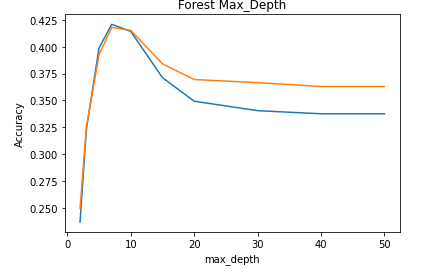
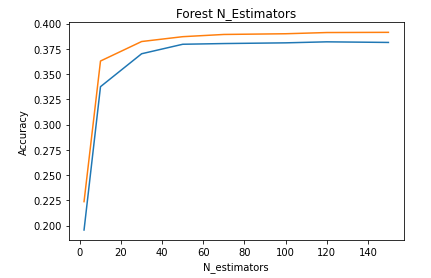

In [24]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#Check for Error and find Best n_estimators:
def checkNumEst():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in [2, 10, 30, 50, 70, 100, 120, 150]:
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nEst,accList, label="line1")
    plt.plot(nEst,cvList, label="line2")
    plt.title("Forest N_Estimators")
    plt.xlabel('N_estimators')
    plt.ylabel('Accuracy')
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
    
def fMaxDepth():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in [2, 3, 5, 7, 10, 15, 20, 30, 40, 50]:
        forest = RandomForestRegressor(n_estimators=10, max_depth=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("max_depth: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nEst,accList, label="line1")
    plt.plot(nEst,cvList, label="line2")
    plt.title("Forest Max_Depth")
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)

#checkNumEst() 
#fMaxDepth()

#### Forest Final Prediction

In [25]:
forestEst=100
forestDepth=8
forest = RandomForestClassifier(n_estimators=forestEst,
                                max_depth=forestDepth, random_state = 0)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forest_r2 = r2_score(y_test, y_pred).round(4)  
forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("Random forest AUC: ", forest_auc) 
print("Random forest r2: ", forest_r2)

forestMAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Random forest MAE: ", forestMAE)

#CROSS VALIDATE TEST RESULTS:
forestScore = forest.score(X_test, y_test).round(4)  # train test 
forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
forestCV=forestCV['test_score'].mean().round(4)
print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")

Random forest AUC:  0.794
Random forest r2:  0.1748
Random forest MAE:  0.21
Forest Score:  0.7937 || 0.169 cross validate.


# Test Data

In [26]:
testDF=pd.read_csv(test)
ID=testDF['PassengerId']

testDF['VIP']=testDF['VIP'].astype('str').replace({'False':0, 'True':1})
testDF['CryoSleep']=testDF['CryoSleep'].astype('str').replace({'False':0, 'True':1})
testDF['HomePlanet']=testDF['HomePlanet'].replace({'Earth':2, 'Europa':1, 'Mars':0})

testDF['Cabin']=testDF['Cabin'].astype('str').str[0]
cabinDic={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'n':7, 'T':8}
testDF['Cabin']=testDF['Cabin'].replace(cabinDic)

testDF['Destination']=testDF['Destination'].astype('str').str[0]
destDic={'T':2, '5':1, 'P':0}
testDF['Destination']=testDF['Destination'].replace(destDic)

#Name Features:
testDF[['First','Last']] = testDF.Name.apply(lambda x: pd.Series(str(x).split(" ")))

numList=[]
lastUnique=list(testDF['Last'].unique())
for name in testDF['Last']:
    if str(name) not in lastUnique:
        numList.append(1)
    else:
        numList.append(0)
testDF['Alone']=numList

#Match DF Features:
features=X.columns
testDF=testDF[features]

testDF=testDF.fillna(testDF.mean())
testDF.head()

,HomePlanet,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Alone
0,2.0,6,27.0,0.0,0.0,0.0,0.0,0.0,0
1,2.0,5,19.0,0.0,9.0,0.0,2823.0,0.0,0
2,1.0,2,31.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,2,38.0,0.0,6652.0,0.0,181.0,585.0,0
4,2.0,5,20.0,10.0,0.0,635.0,0.0,0.0,0


# Final Predictions

In [27]:
test_predictions = forest.predict(testDF)
tupleData = list(zip(ID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Transported'])
output['Transported']=output['Transported'].replace({0:False, 1:True})
print(output.shape)
print(output.dtypes)
output.head()

(4277, 2)
PassengerId    object
Transported      bool
dtype: object


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [28]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
